In [1]:
# imports
import os
import glob
import rawpy
import cv2
from tqdm.notebook import tqdm, trange
import numpy as np
import git
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip


# from astropy.nddata import CCDData
# from astropy.stats import mad_std
# import ccdproc as ccdp

# test data sourced from https://www.reddit.com/r/astrophotography/comments/9q7tum/andromeda_galaxy_raw_photos_to_experiment/

In [12]:
# global variables
test_data_dir = os.path.join(os.path.abspath("."), "test_data")
fits_image_filename = os.path.join("/Users/austinlucaslake/code/astrosight/src/astrosight/test_data", "dark.1s.20.fits")
assert os.path.isfile(fits_image_filename), "No file found"

In [25]:
from astropy.io import fits

with fits.open(fits_image_filename) as hdul:
    image = hdul[0].data
    print(type(image))

<class 'numpy.ndarray'>


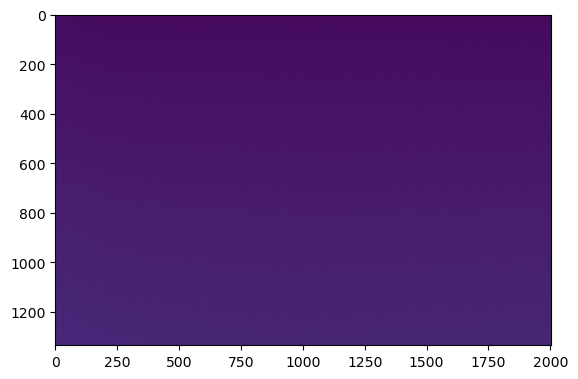

In [24]:
plt.imshow(image)

In [2]:
def register(
    calibrated_image: np.ndarray[np.uint16],
    features: tuple,
    base_features: tuple,
    detector_type: str,
    match_percent_threshhold: float = 0.8,
) -> np.ndarray[int]:
    """Registers and aligned an image

    Parameters
    ----------
    calibrated_image: numpy.ndarray[numpy.uint16]
        Calibrated image

    features: tuple
        Keypoints and descriptors from features of interest for current image

    base_features: tuple
        Keypoints and descriptors for features of interest of base image

    match_percent_threshhold: float
        Percentage threshold of matches to include in registration process

    Returns
    -------
    registered_image: numpy.ndarray[numpy.uint16]
        Registered image
    """
    keypoints, descriptors = features
    base_keypoints, base_descriptors = base_features

    matcher = (
        cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        if detector_type != "SIFT"
        else cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    )
    matches = matcher.match(descriptors, base_descriptors, None)
    matches = sorted(matches, key=lambda x: x.distance)

    if matcher == "SIFT":
        good_matches = []
        for m1, m2 in matches:
            if m1.distance < 0.6 * m2.distance:
                good_matches.append(m1)
        matches = good_matches
    else:
        matches = matches[: int(len(matches) * match_percent_threshhold)]

    features = [keypoints, base_keypoints]
    points = np.empty((2, len(matches), 2))
    for i, feature in enumerate(features):
        for j, match in enumerate(matches):
            points[i, j, :] = feature[match.trainIdx if i else match.queryIdx].pt

    homography, mask = cv2.findHomography(points[0], points[1], cv2.RANSAC)
    registered_image = cv2.warpPerspective(
        calibrated_image,
        homography,
        (calibrated_image.shape[1], calibrated_image.shape[0]),
    )
    return registered_image

In [3]:
def get_calibration_frames(base_dir: str = "") -> tuple[np.ndarray[int]]:
    """Generates calibration frame from a specified image set

    Paramters
    ---------
    base_dir:

    Returns
    -------
    master_bias: numpy.ndarray[numpy.uint16]
        Master bias calibration frame

    master_dark: numpy.ndarray[numpy.uint16]
        Master dark calibration frame

    master_flat: numpy.ndarray[numpy.uint16]
        Master flat calibration frame
    """

    try:
        bias_files = os.listdir(os.path.join(os.path.abspath(base_dir), "BIAS"))
        master_bias = None
        for i, bias_file in enumerate(tqdm(bias_files, desc="Loading bias frames")):
            with rawpy.imread(bias_file) as raw:
                if master_bias is None:
                    np.empty((len(bias_files), *raw.raw_image.shape))
                master_bias[i] = raw.raw_image
        master_bias = np.mean(master_bias, axis=0)
    except (rawpy.LibRawError, FileNotFoundError):
        master_bias = None

    try:
        dark_files = os.listdir(os.path.join(os.path.abspath(base_dir), "DARKS"))
        master_dark = None
        for i, dark_file in enumerate(tqdm(dark_files, desc="Loading dark frames")):
            with rawpy.imread(dark_file) as raw:
                if master_dark is None:
                    master_dark = np.empty((len(dark_files), *raw.raw_image.shape))
                master_flat[i] = raw.raw_image
            if master_bias:
                master_dark[i] -= master_bias
        master_dark = np.mean(master_dark, axis=0)
    except (rawpy.LibRawError, FileNotFoundError):
        master_dark = None

    try:
        flat_files = os.listdir(os.path.join(os.path.abspath(base_dir), "FLATS"))
        master_flat = None
        for i, flat_file in enumerate(tqdm(flat_files, desc="Loading flat frames")):
            with rawpy.imread(flat_file) as raw:
                if master_flat is None:
                    master_flat = np.empty((len(flat_files), *raw.raw_image.shape))
                master_flat[i] = raw.raw_image
            if master_bias:
                master_flat[i] -= master_bias
        master_flat = np.mean(master_flat, axis=0)
    except (rawpy.LibRawError, FileNotFoundError):
        master_flat = None

    return master_bias, master_dark, master_flat

In [4]:
def scale_to_8bit(image: np.ndarray[np.uint16]) -> np.ndarray[np.uint8]:
    scaled_image = (image / 257).astype(np.uint8)
    return scaled_image

In [5]:
def calibrate(
    image: np.ndarray[np.uint16],
    master_bias: np.ndarray[np.uint16] = None,
    master_dark: np.ndarray[np.uint16] = None,
    master_flat: np.ndarray[np.uint16] = None,
) -> np.ndarray[np.uint16]:
    """Calibrates an image

    Parameters
    ----------
    image: str
        Uncalibrated image

    master_bias: numpy.ndarray[numpy.uint16]
        Master bias calibration frame

    master_dark: numpy.ndarray[numpy.uint16]
        Master dark calibration frame

    master_flat: numpy.ndarray[numpy.uint16]
        Master flat calibration frame

    Returns
    -------
    calibrated_image: str
        Calibrated image
    """
    image = 1.0 * image  # floating point conversion for data retention in computation
    if master_bias:
        image = image - master_dark
    if master_bias:
        image = image - master_bias
    if master_flat:
        image = image / master_flat
    image[image < 0] = 0
    calibrated_image = image.astype(np.uint16)
    return calibrated_image

In [6]:
def load(
    image_file: str,
    master_bias: np.ndarray[np.uint16] = None,
    master_dark: np.ndarray[np.uint16] = None,
    master_flat: np.ndarray[np.uint16] = None,
    detector_type: str = "ORB",
) -> np.ndarray[np.uint16]:
    """Loads and processes an astrophotography image at a specified file path

    Paramters
    ---------
    image_file: str
        Full path to specified image file

    master_bias: numpy.ndarray[numpy.uint16]
        Master bias calibration frame

    master_dark: numpy.ndarray[numpy.uint16]
        Master dark calibration frame

    master_flat: numpy.ndarray[numpy.uint16]
        Master flat calibration frame

    Returns
    -------
    calibrated_image: numpy.ndarray[numpy.uint16]
        Calibrated image

    keypoints: tuple
        Keypoints from features of interest for calibrated image

    descriptors: tuple
        Descriptors from features of interest for calibrated image
    """

    try:
        with rawpy.imread(image_file) as raw:
            image = raw.raw_image

            image = calibrate(image, master_bias, master_dark, master_flat)
            np.copyto(raw.raw_image, image)

            params = rawpy.Params(
                gamma=(1, 1),
                no_auto_scale=False,
                no_auto_bright=True,
                output_bps=16,
                use_camera_wb=True,
                use_auto_wb=False,
                user_wb=None,
                output_color=rawpy.ColorSpace.sRGB,
                demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,
                fbdd_noise_reduction=rawpy.FBDDNoiseReductionMode.Full,
                dcb_enhance=False,
                dcb_iterations=0,
                half_size=False,
                median_filter_passes=0,
                user_black=0,
            )

            processed_image = raw.postprocess(params)
            if detector_type == "ORB":
                detector = cv2.ORB_create()
            elif detector_type == "SIFT":
                detector = cv2.SIFT_create()
            elif detector_type == "AKAZE":
                detector = cv2.AKAZE_create()
            else:
                raise ValueError("Invalid feature detector")
            keypoints, descriptors = detector.detectAndCompute(
                scale_to_8bit(processed_image), None
            )
    except rawpy.LibRawError:
        print("Invalid image file")
    except ValueError:
        print("Invalid feature detector")
    else:
        return processed_image, keypoints, descriptors
    return None, None, None

In [7]:
def show(stacked_image: np.ndarray[np.uint16]) -> None:
    """Shows a stacked astrophotography image

    Paramters
    ---------
    stacked_image: numpy.ndarray[numpy.uint16]
        Stacked image to be displayed

    Returns
    -------
    None
    """

    fig, ax = plt.subplots()
    ax.imshow(scale_to_8bit(stacked_image))
    plt.style.use("dark_background")
    plt.title("Stacked Image")
    plt.axis("off")
    plt.savefig("stacked_image.png")
    plt.show()
    plt.close(fig)

In [16]:
def stack(base_dir, params: dict = None) -> np.ndarray[np.uint16]:
    """Stacks astrophotography images

    Parameters
    ----------
    base_dir: dict[list[str]]
        Absolute paths to light, dark, bias, and flat images
        {'light': [...], 'dark': [...], 'bias': [...], 'flat': [...]}

    params: dict
        Stacking parameters

    Returns
    -------
    stacked_image: numpy.ndarray[numpy.uint16]
        Stacked image
    """
    try:
        master_dark, master_bias, master_flat = get_calibration_frames(base_dir)
        image_dir = f"{base_dir}/IMAGES/*.*"
        image_stack = None
        for i, image_file in enumerate(
            tqdm(
                [image_file for image_file in glob.glob(image_dir)],
                desc="Loading images",
                disable=(params["verbose"]),
            )
        ):
            calibrated_image, keypoints, descriptors = load(
                image_file=image_file,
                master_bias=master_bias,
                master_dark=master_dark,
                master_flat=master_flat,
                params=params,
            )
            if calibrated_image:
                if image_stack is None:
                    base_keypoints, base_descriptors = keypoints, descriptors
                    # image_stack = np.empty((len(image_sets["light"]), *calibrated_image.shape))
                    stacked_image = calibrated_image
                else:
                    registered_image = register(
                        calibrated_image,
                        features=(keypoints, descriptors),
                        base_features=(base_keypoints, base_descriptors),
                        detector_type=params["detector_type"],
                    )
                    # image_stack[i] = registered_image
                    stacked_image = sigma_clip(stacked_image + registered_image)
                # stacked_image = np.mean(image_stack, axis=0)
                if params["verbose"]:
                    show(stacked_image)
    except rawpy.LibRawError:
        if params["verbose"]:
            print("R")
    else:
        return stacked_image
    return None

In [17]:
stack("test_data")

Loading bias frames:   0%|          | 0/10 [00:00<?, ?it/s]

Loading dark frames:   0%|          | 0/14 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

In [19]:
import tkinter as tk
from tkinter import filedialog as fd


def callback():
    name = fd.askopenfilenames()
    print(name)

In [28]:
from treelib import Node, Tree


def preview(frame):
    with rawpy.imread(frame) as raw:
        return raw.raw_image


def add_children(files, tree):
    for key in files.keys:
        tree.create_node(files[key], files[key], parent=key)
        add_children(files, tree, files[key])


def show_tree(files):
    tree = Tree()
    root = "image tree"
    tree.create_node(root, root)
    add_children(files, tree, files)
    tree.show()

In [1]:
import sys
from PyQt5.QtGui import QGuiApplication
from PyQt5.QtQml import QQmlApplicationEngine


def App():
    app = QGuiApplication(sys.argv)

    engine = QQmlApplicationEngine()
    engine.quit.connect(app.quit)
    engine.load("main.qml")
    sys.exit(app.exec())


App()

qml: current index QPersistentModelIndex()
file:///Users/austinlucaslake/code/astrosight/src/astrosight/main.qml:138: ReferenceError: fileManagement is not defined
file:///Users/austinlucaslake/code/astrosight/src/astrosight/main.qml:101: ReferenceError: fileSystemModel is not defined
file:///Users/austinlucaslake/code/astrosight/src/astrosight/main.qml:114: ReferenceError: fileSystemModel is not defined
qml: Canceled


SystemExit: 0

/Users/austinlucaslake/conda/envs/astrosight/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
def select_frames():
    files = {}
    print("Select core images...")
    files["light"] = fd.askopenfilenames()
    print(f"{len(files['light'])} light frames elected")
    files["dark"] = fd.askopenfilenames()
    print(f"{len(files['dark'])} dark frames elected")
    files["bias"] = fd.askopenfilenames()
    print(f"{len(files['bias'])} bias frames elected")
    files["flat"] = fd.askopenfilenames()
    print(f"{len(files['flat'])} flat frames elected")
    print("Current image tree")
    show_tree(files)


select_frames()

Select core images...
24 light frames elected
14 dark frames elected
10 bias frames elected
0 flat frames elected
Current image tree


TypeError: add_children() takes 2 positional arguments but 3 were given